In [4]:
from pymongo  import MongoClient
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes, preprocessing, model_selection, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection
#! pip install scikit-surprise
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Chargement des données AVIS

In [5]:
# Pour lancer le demon de la base de données mongod
# source ~/.bash_profile 
# mongod --config ~/db/mongod.cfg 
client = MongoClient(host="localhost", port=27017)
db = client["PLDAC_01"] 
collection = db["avis"]
collection_det = db["details"]

In [6]:
df_avis = pd.DataFrame(list(collection.find())).loc[:,["author","title","note","date_published"]]
df_avis.head(5)

author      title  note       date_published
0  Monsieur Guillaume  Mariposas   8.0  2021-01-27 11:06:44
1          morlockbob  Mariposas   7.0  2020-10-18 10:04:21
2              SwatSh  Mariposas   7.0  2021-02-01 08:35:08
3     Timi JeuxATheme  Mariposas   8.0  2020-11-19 17:04:57
4           prunelles  Mariposas   9.0  2021-05-24 12:43:18

In [7]:
df_details = pd.DataFrame(list(collection_det.find())).loc[:,["titre","categories"]]
df_details = df_details.set_index('titre')
print(f"Taille de la base details: {len(df_details)}")
print(f"Nombre de categoies: {df_details['categories'].nunique()}")
print(df_details.head())

Taille de la base details: 20234
Nombre de categoies: 2691
                                                                 categories
titre                                                                      
Marvel United                                                              
Mariposas                                                                  
Quetzal                   Enchères|Aventures dans la jungle|Collection /...
Alien - Kit de Démarrage                                                   
The LOOP                  Card-driven|Combinaison|Coopération|Deck build...


In [8]:
num_utilisateurs  = df_avis["author"].nunique()
num_jeux  = df_avis["title"].nunique()

print(f"Il y a {num_utilisateurs} utilisateurs et {num_jeux} jeux dans la base.")
print("Taile de la base:\n  ",len(df_avis))

Il y a 13623 utilisateurs et 10709 jeux dans la base.
Taile de la base:
   246524


## Stastistique sur les utilisateurs ayant noté plusieurs fois un jeu.

In [9]:
df_avis_unique = df_avis.groupby(['author','title']).value_counts()
df_avis_unique.head(10)

author            title                                note  date_published     
#yuyu#            Bubblee Pop                          8.5   2019-01-19 23:11:33    2
                  KARMAKA                              8.8   2018-02-25 09:01:19    2
$hadow            Le Dilemme du Roi                    9.0   2021-01-03 21:14:16    5
$lebat@$          Deluxe Camping                       10.0  2007-11-06 12:28:47    1
&lo               Sporz Original Outbreak              10.0  2011-01-18 12:28:59    1
*FitzChevalerie*  7 Wonders - Extension "Cities"       8.0   2012-11-20 13:36:22    1
                  7 Wonders - Extension "Wonder Pack"  7.4   2013-10-14 20:35:59    1
                  A Few Acres of Snow                  10.0  2012-05-23 12:29:05    1
                  Archipelago                          10.0  2012-10-16 13:36:22    1
                  Archipelago : Solo Expansion         10.0  2012-12-06 18:14:14    1
dtype: int64

Nous observons qu'il y'a des duplications de mêmes lignes.

## Suppression des duplications

In [10]:
# suppression des duplications
df_avis = df_avis.drop_duplicates(subset=['author','title','note','date_published'])
df_avis.head()

author      title  note       date_published
0  Monsieur Guillaume  Mariposas   8.0  2021-01-27 11:06:44
1          morlockbob  Mariposas   7.0  2020-10-18 10:04:21
2              SwatSh  Mariposas   7.0  2021-02-01 08:35:08
3     Timi JeuxATheme  Mariposas   8.0  2020-11-19 17:04:57
4           prunelles  Mariposas   9.0  2021-05-24 12:43:18

## Pour chaque couple utilisateur, jeu on récupère la liste des notes avec la date

In [11]:
# Regroupement par auteur et titre, et création de la liste de tuples pour chaque cas
df_notes = df_avis.groupby(['author', 'title']).apply(lambda x: list(zip(x['note'], x['date_published'])))
notes = df_notes[df_notes.apply(len) >= 2]
notes_dict = notes.to_dict()
notes

author        title                                       
Actorios      Footmania                                       [(6.0, 2006-06-03 12:28:42), (8.0, 2004-09-11 ...
Belboudin     Poker                                           [(5.0, 2014-11-11 17:31:27), (5.5, 2015-10-02 ...
Benjyskahn    Les Colons de Catane : Politique & Intrigues    [(9.0, 2021-06-05 11:51:39), (6.0, 2021-06-05 ...
Biff          Alcatraz                                        [(8.0, 2009-02-08 12:28:52), (8.0, 2006-08-13 ...
Clem_Achille  Trivial Pursuit - Star Wars                     [(8.0, 2010-12-19 12:28:59), (6.0, 2010-12-18 ...
                                                                                    ...                        
thespios      Poker                                           [(9.0, 2021-11-22 22:24:22), (8.0, 2021-09-17 ...
winforlife    Gangster                                        [(8.0, 2008-01-05 12:28:48), (4.0, 2007-06-18 ...
yahndrev      Merlin                         

In [12]:
authors_notes = list(set(notes.index.get_level_values('author')))
titles_notes = list(set(notes.index.get_level_values('title')))

In [13]:
print(f"Il y'a {len(notes)} notes qui ont été renoté au moins une deuxième fois correspondant à {100*len(notes)/len(df_avis)} % des notes")
print(f"Il y'a {len(authors_notes)} utilisateurs qui ont renoté au moins une deuxième fois au moins un jeu corresspondant à {100*len(authors_notes)/num_utilisateurs} % des utilisateurs")
print(f"Il y'a {len(titles_notes)} jeux qui ont été renoté au moins une deuxième fois correspondants à {100*len(titles_notes)/num_jeux} % des jeux")

Il y'a 111 notes qui ont été renoté au moins une deuxième fois correspondant à 0.0630030309566244 % des notes
Il y'a 81 utilisateurs qui ont renoté au moins une deuxième fois au moins un jeu corresspondant à 0.5945826910372165 % des utilisateurs
Il y'a 65 jeux qui ont été renoté au moins une deuxième fois correspondants à 0.6069661032776169 % des jeux


In [14]:
# Trier les sous-listes de notes_dict par date
for key, value in notes_dict.items():
  notes_dict[key] = sorted(value, key=lambda x: x[1])

### Ecriture des renotes dans un fichier
Juste pour voir comment les utilisateurs changent leurs notations

In [15]:
import json

# Conversion des tuples en chaînes de caractères
notes_dict_str = {}
for (author,title ), value in notes_dict.items():
  new_key = str(author) + " ::&:: " + str(title) 
  notes_dict_str[new_key] = value

# Nom du fichier dans lequel écrire le dictionnaire
filename = 'notes_renotees.json'

# Écriture du dictionnaire dans le fichier en format JSON
with open(filename, 'w') as f:
    json.dump(notes_dict_str, f)

# Affichage d'un message confirmant l'écriture du fichier
print(f"Le dictionnaire a été écrit dans le fichier {filename} en format JSON.")


Le dictionnaire a été écrit dans le fichier notes_renotees.json en format JSON.


### Les utilisateurs qui améliorent leurs notes vs ceux qui détériorent les leurs

41 améliorent leurs notes vs 28 détériorent leurs notes vs 42 ont remis la même note


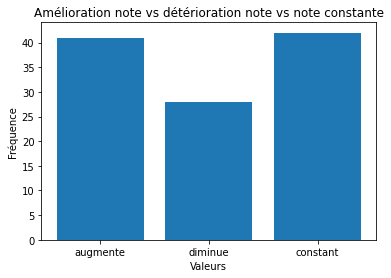

In [16]:
import matplotlib.pyplot as plt

count_plus = 0
count_moins = 0
count_const = 0

# Parcours de chaque sous-liste
for key, value in notes_dict.items():
  croissant = True
  for i in range(1, len(value)):
    if value[i][0] <= value[i-1][0]:
      croissant = False
      break
  if croissant:
      count_plus += 1
  
  decroissant = True
  for i in range(1, len(value)):
    if value[i][0] >= value[i-1][0]:
      decroissant = False
      break
  if decroissant:
      count_moins += 1
  
  constant = True
  for i in range(1, len(value)):
    if value[i][0] != value[i-1][0]:
      constant = False
      break
  if constant:
      count_const += 1

print(f"{count_plus} améliorent leurs notes vs {count_moins} détériorent leurs notes vs {count_const} ont remis la même note")
# Création du diagramme à barres
plt.bar(['augmente','diminue','constant'], [count_plus,count_moins,count_const])

# Ajout de la légende et du titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Amélioration note vs détérioration note vs note constante')

# Affichage du diagramme
plt.show()


Ce résultat nous offrent plusieurs chemins potentiels à explorer:
- garder la première note
- garder la dernière note (meilleur choix à mon sens)
- garder la note maximale
- garder la note minimale
- garder la note moyenne
- tout garder
- ne rien garder (pourquoi pas)
- pour ceux qui ont remis la note ?

# Garder la dernière note

In [17]:
print(len(df_avis))
# Convertir la colonne 'date_published' en type de données datetime
df_avis['date_published'] = pd.to_datetime(df_avis['date_published'])

# Trier le DataFrame par 'author', 'title' et 'date_published'
df_avis = df_avis.sort_values(['author', 'title', 'date_published'])

# Grouper par 'author' et 'title' et prendre la dernière 'date_published' et la note correspondante
df_avis = df_avis.groupby(['author', 'title']).agg({'note': 'last', 'date_published': 'last'}).reset_index()

len(df_avis)

176182


176071

In [18]:
df_avis.head()

author                    title  note      date_published
0    #yuyu#              Bubblee Pop   8.5 2019-01-19 23:11:33
1    #yuyu#                  KARMAKA   8.8 2018-02-25 09:01:19
2    $hadow        Le Dilemme du Roi   9.0 2021-01-03 21:14:16
3  $lebat@$           Deluxe Camping  10.0 2007-11-06 12:28:47
4       &lo  Sporz Original Outbreak  10.0 2011-01-18 12:28:59

## 1. Statistiques sur le nombre d'utilisateurs en fonction du nombre minimum de notes

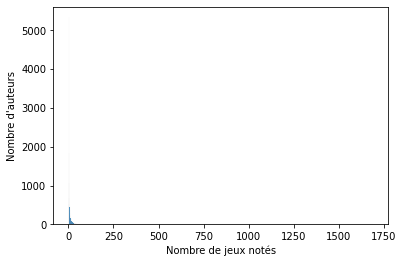

In [19]:
import seaborn as sns
count_per_author = df_avis['author'].value_counts()
count_per_author.head()

sns.histplot(data=[ ni for ni in count_per_author if ni <= 300], bins=range(1, count_per_author.max()+2))

plt.xlabel('Nombre de jeux notés')
plt.ylabel('Nombre d\'auteurs')

plt.show()


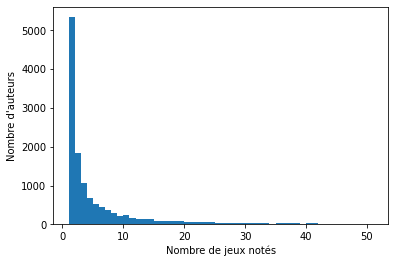

In [20]:
count_per_author = df_avis['author'].value_counts()

count_per_author_filtered = count_per_author[count_per_author <= 50]

count_per_author_filtered.plot(kind='hist', bins=range(1, count_per_author_filtered.max()+2))

plt.xlabel('Nombre de jeux notés')
plt.ylabel('Nombre d\'auteurs')

plt.show()

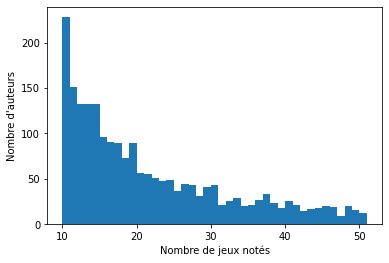

In [21]:
count_per_author = df_avis['author'].value_counts()

count_per_author_filtered = count_per_author[count_per_author <= 50]
count_per_author_filtered.plot(kind='hist', bins=range(10, count_per_author_filtered.max()+2))

plt.xlabel('Nombre de jeux notés')
plt.ylabel('Nombre d\'auteurs')

plt.show()

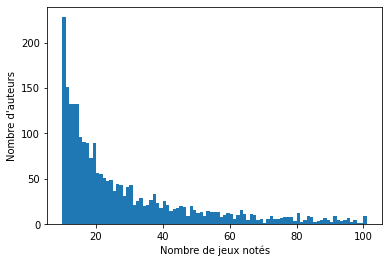

In [22]:
count_per_author = df_avis['author'].value_counts()

count_per_author_filtered = count_per_author[count_per_author <= 100]
count_per_author_filtered.plot(kind='hist', bins=range(10, count_per_author_filtered.max()+2))

plt.xlabel('Nombre de jeux notés')
plt.ylabel('Nombre d\'auteurs')

plt.show()

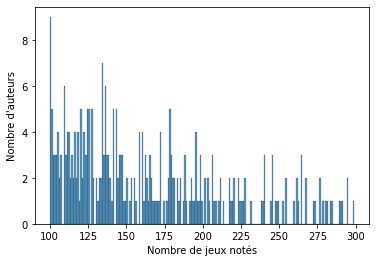

In [23]:
count_per_author_filtered = count_per_author[count_per_author >= 100]
count_per_author_filtered = count_per_author_filtered[count_per_author_filtered <= 300]

sns.histplot(data=count_per_author_filtered, x=count_per_author_filtered, bins=range(100, count_per_author_filtered.max()+2))

plt.xlabel('Nombre de jeux notés')
plt.ylabel('Nombre d\'auteurs')

plt.show()

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

l_min = [0,5,10,20,30,50,100,200,300]
n_authors = []
n_titles = []
tailles_df = []

df_avis = df_avis[['author','title','note']]
authors_counts = df_avis['author'].value_counts()
for min_note in l_min:
  authors = authors_counts[authors_counts >= min_note].index.to_list()
  n_authors.append(np.unique(authors).shape[0])
  
  df_avis_k = df_avis[df_avis['author'].isin(authors)]
  n_titles.append(df_avis_k["title"].nunique())
  tailles_df.append(len(df_avis_k))

print("Nombre minimums de notes requis:\n  ",l_min)
print("Liste du nombre d'authors restants:\n  ",n_authors)
print("Liste du nombre de jeux restants:\n  ",n_titles)
print("Taille de la base resultante:\n  ",tailles_df)

Nombre minimums de notes requis:
   [0, 5, 10, 20, 30, 50, 100, 200, 300]
Liste du nombre d'authors restants:
   [13623, 4701, 2849, 1631, 1176, 734, 359, 128, 61]
Liste du nombre de jeux restants:
   [10709, 10473, 10284, 9985, 9810, 9502, 8884, 7841, 6941]
Taille de la base resultante:
   [176071, 161159, 148961, 132383, 121419, 104510, 78541, 46182, 29867]


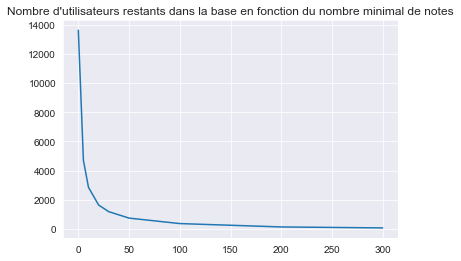

In [25]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_authors)
plt.title("Nombre d'utilisateurs restants dans la base en fonction du nombre minimal de notes")
plt.show()

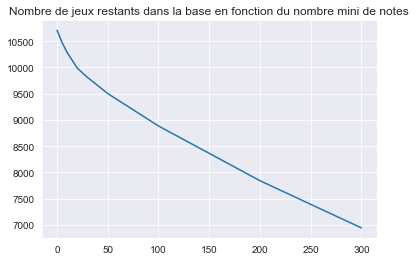

In [26]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=n_titles)
plt.title("Nombre de jeux restants dans la base en fonction du nombre mini de notes")
plt.show()

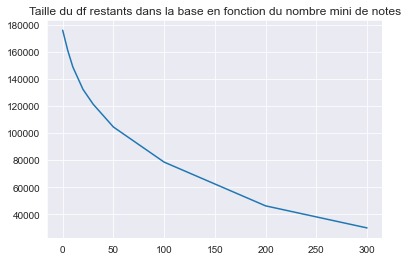

In [27]:
sns.set_style("darkgrid")
sns.lineplot(x=l_min,y=tailles_df)
plt.title("Taille du df restants dans la base en fonction du nombre mini de notes")
plt.show()

Nous avons decidé de prendre les trois cas suivants au vus des statisques après suppression de certains cas d'utilisateurs: 
- les utilisateurs ayant noté au moins 10 jeux
- les utilisateurs ayant noté au moins 50 jeux
- les utilisateurs ayant noté au moins 100 jeux
- les utilisateurs ayant noté au moins 200 jeux

## Déduction des quatres bases sur les quelles nous allons travailer et faire des comparaisons.

- df_avis_10 contient les données avec des utilisateurs ayant noté au moins 10 jeux
- df_avis_50 contient les données avec des utilisateurs ayant noté au moins 50 jeux
- df_avis_100 contient les données avec des utilisateurs ayant noté au moins 100 jeux
- df_avis_200 contient les données avec des utilisateurs ayant noté au moins 200 jeux


In [28]:
print(f"Taille de la base avant suppression:\n      --> {len(df_avis)}")

authors = df_avis['author'].value_counts()
authors_10  = authors[authors >= 10 ].index.to_list()
authors_50 = authors[authors >= 50].index.to_list()
authors_100 = authors[authors >= 100].index.to_list()
authors_200 = authors[authors >= 200].index.to_list()


df_avis_10  = df_avis[df_avis['author'].isin(authors_10)]
df_avis_50 = df_avis[df_avis['author'].isin(authors_50)]
df_avis_100 = df_avis[df_avis['author'].isin(authors_100)]
df_avis_200 = df_avis[df_avis['author'].isin(authors_200)]


print(f"Taille de la base après suppression des utilisateurs ayant noté moins d'un certain nombre de jeux:")
print(f"  10  --> {len(df_avis_10)}")
print(f"  50 --> {len(df_avis_50)}")
print(f"  100 --> {len(df_avis_100)}")
print(f"  200 --> {len(df_avis_200)}")

Taille de la base avant suppression:
      --> 176071
Taille de la base après suppression des utilisateurs ayant noté moins d'un certain nombre de jeux:
  10  --> 148961
  50 --> 104510
  100 --> 78541
  200 --> 46182


- La base df_avis_10  contient **148961** lignes pour **2849** utilisateurs et **10284** jeux.
- La base df_avis_50 contient **104510** lignes pour **734** utilisateurs et **9502** jeux.
- La base df_avis_100 contient **78541** lignes pour **359** utilisateurs et **8884** jeux.
- La base df_avis_200 contient **46182** lignes pour **128** utilisateurs et **7841** jeux.


## Jeux populaires

In [29]:
jeux_counts = df_avis.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 20 jeux les plus populaires dans la base:\n ",jeux_counts[:20])


Les 20 jeux les plus populaires dans la base:
  title
Shogun                                   172
Non Merci                                158
Boomerang                                156
Eclipse                                  155
Les mystères de Pékin                    155
Mare Nostrum                             153
Dune                                     153
Camelot                                  151
Poker                                    151
Intrigue                                 151
Samuraï                                  151
Guillotine                               151
Elysium                                  151
Not Alone                                150
Battlestar Galactica                     150
Clank!                                   150
Clans                                    150
Notre Dame - édition 10e anniversaire    150
Carcassonne                              150
Civilisation                             150
Name: note, dtype: int64


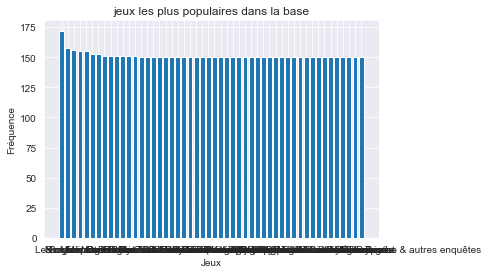

In [30]:
# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 10 jeux:
 title
Non Merci                    158
Shogun                       153
Camelot                      151
Uno Deluxe                   150
La Crique des Pirates        150
Gang Of Four                 150
Takenoko                     150
Marrakech - Astérix          150
La Traversée du Désert       150
Coloretto : 10 ans déjà      150
La Guerre des Moutons        150
Bang!                        150
Cluedo - Les bons voyages    150
L'Île interdite              150
Hanabi                       150
Seasons                      150
L'Âge de Pierre              150
Kuhhandel Master             150
Tigris & Euphrates           150
Service Compris !            150
Name: note, dtype: int64


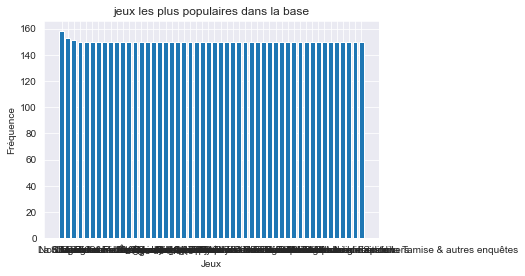

In [31]:
jeux_counts = df_avis_10.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 10 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 50 jeux:
 title
Les Chevaliers de la Table Ronde    150
L'Âge de Pierre                     150
La Guerre des Moutons               150
Jamaïca                             150
Time's Up !                         149
Dice Town                           149
Camelot                             149
Elixir                              149
Agricola                            149
Small World                         149
Pingouins                           148
Dominion                            148
Yspahan                             148
Mr. Jack - London                   148
Jungle Speed                        148
Citadelles : quatrième édition      148
Lost Cities - The Boardgame         147
Les Aventuriers du Rail             147
Caylus                              147
Bang!                               147
Name: note, dtype: int64


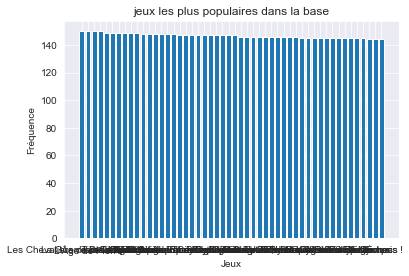

In [32]:
jeux_counts = df_avis_50.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 50 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 100 jeux:
 title
La Guerre des Moutons               146
Les Chevaliers de la Table Ronde    144
Small World                         144
Time's Up !                         143
Elixir                              142
L'Âge de Pierre                     141
Dominion                            141
Agricola                            139
Mr. Jack - London                   138
Citadelles : quatrième édition      138
Race for the Galaxy                 138
6 qui prend !                       138
Catan                               137
Caylus                              137
Les Aventuriers du Rail             137
Jamaïca                             137
Yspahan                             136
Lost Cities - The Boardgame         135
Formula D                           135
Bang!                               135
Name: note, dtype: int64


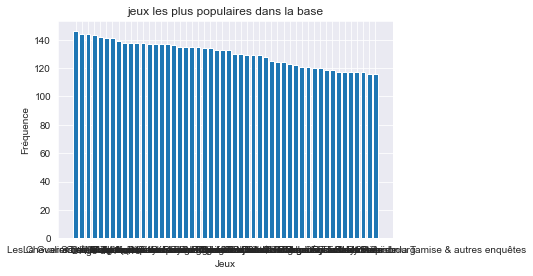

In [33]:
jeux_counts = df_avis_100.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 100 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 200 jeux:
 title
Les Aventuriers du Rail             82
Small World                         82
L'Âge de Pierre                     82
La Guerre des Moutons               82
Dominion                            79
Citadelles : quatrième édition      79
Les Chevaliers de la Table Ronde    78
6 qui prend !                       77
Jamaïca                             75
Caylus                              75
Agricola                            74
Time's Up !                         74
Coloretto : 10 ans déjà             73
Pandémie                            73
Carcassonne                         72
Jungle Speed                        72
Lost Cities - The Boardgame         71
Race for the Galaxy                 71
Dixit                               71
Pingouins                           69
Name: note, dtype: int64


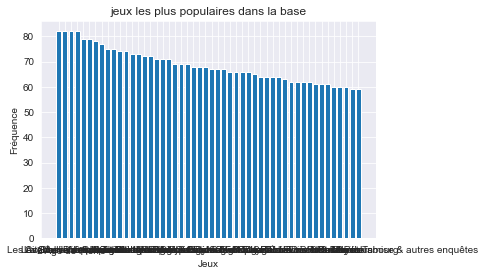

In [34]:
jeux_counts = df_avis_200.groupby('title')["note"].count().sort_values(ascending=False)
jeux_populaires = jeux_counts.index.tolist()
print("Les 10 jeux les plus populaires dans la base, avec les utilisateurs ayant noté au moins 200 jeux:\n",jeux_counts[:20])

# Création du diagramme à barres
n = 50
plt.bar(jeux_populaires[:n], jeux_counts.values[:n])

# Ajout de la légende et du titre
plt.xlabel('Jeux')
plt.ylabel('Fréquence')
plt.title('jeux les plus populaires dans la base')

# Affichage du diagramme
plt.show()

La distribution est un peu plate.
La liste des jeux les plus populaires n'est pas statique selon les bases considérées.

## Separation des données en plusieurs jeux de données pour la validation croisée(5 paquets de train/test).
Récupération de la liste de tous les jeux qui pourront être recommendés et des jeux les plus populaires.

In [35]:

from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True,random_state=0)

splits_10 = []
for train, test in kf.split(df_avis_10):
  X_train = df_avis_10.iloc[train].copy()
  X_test  = df_avis_10.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_10.append((X_train,X_test,(jeux_existants,jeux_populaires)))


splits_50 = []
for train, test in kf.split(df_avis_50):
  X_train = df_avis_50.iloc[train].copy()
  X_test  = df_avis_50.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_50.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_100 = []
for train, test in kf.split(df_avis_100):
  X_train = df_avis_100.iloc[train].copy()
  X_test  = df_avis_100.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_100.append((X_train,X_test,(jeux_existants,jeux_populaires)))

splits_200 = []
for train, test in kf.split(df_avis_200):
  X_train = df_avis_200.iloc[train].copy()
  X_test  = df_avis_200.iloc[test].copy()
  jeux_existants = set(X_train["title"].unique()) # ensemble des jeux existants
  jeux_counts = X_train.groupby('title')["note"].count().sort_values(ascending=False)
  jeux_populaires = jeux_counts.index.tolist()
  splits_200.append((X_train,X_test,(jeux_existants,jeux_populaires)))



print(f"Validation croisée en {len(splits_10)} paquets")
    

Validation croisée en 5 paquets


# Filtrage Collaboratif

In [36]:
jeux_existants_10  = [len(je) for X_train,X_test,(je,jp) in splits_10]
jeux_existants_50 = [len(je) for X_train,X_test,(je,jp) in splits_50]
jeux_existants_100 = [len(je) for X_train,X_test,(je,jp) in splits_100]
jeux_existants_200 = [len(je) for X_train,X_test,(je,jp) in splits_200]


## Création des interactions dans les données train/test avec Lightfm

In [37]:
from lightfm import LightFM
from lightfm.data import Dataset

# (a) Create a dataset
dataset_10  = [Dataset() for i in range(len(splits_10))]
dataset_50 = [Dataset() for i in range(len(splits_50))]
dataset_100 = [Dataset() for i in range(len(splits_100))]
dataset_200 = [Dataset() for i in range(len(splits_200))]


# (b) Create an internal mapping for users and items (We need to consider train + test)
[dataset.fit((x for x in df_avis_10["author"]),
            (x for x in df_avis_10["title"])) for dataset in dataset_10]
[dataset.fit((x for x in df_avis_50["author"]),
            (x for x in df_avis_50["title"])) for dataset in dataset_50]
[dataset.fit((x for x in df_avis_100["author"]),
            (x for x in df_avis_100["title"])) for dataset in dataset_100]
[dataset.fit((x for x in df_avis_200["author"]),
            (x for x in df_avis_200["title"])) for dataset in dataset_200]

# (c) Create the interaction matrices
n10_interactions_10,n10_interactions_50,n10_interactions_100,n10_interactions_200 = [],[],[],[]
for ip in range(len(splits_10)):
    dataset = dataset_10[ip]
    X_train,X_test,je = splits_10[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
    )
    n10_interactions_10.append((train_interactions,test_interactions))
    
    dataset = dataset_50[ip]
    X_train,X_test,je = splits_50[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
    )
    n10_interactions_50.append((train_interactions,test_interactions))
    
    dataset = dataset_100[ip]
    X_train,X_test,je = splits_100[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
    )
    n10_interactions_100.append((train_interactions,test_interactions))
    
    dataset = dataset_200[ip]
    X_train,X_test,je = splits_200[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 10) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 10)  # We only consider 5's as interactions
    )
    n10_interactions_200.append((train_interactions,test_interactions))

/usr/local/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Train the lightFM model


In [38]:
1e-42

1e-42

In [39]:
from lightfm import LightFM
from lightfm.evaluation import reciprocal_rank

l_n_components = [10,20,30,40,50,70,100,200]
l_alpha = [0,1e-5, 1e-45,1e-4, 1e-3]
# l_alpha = [0,1e-48,1e-38, 1e-45]
def executer_reciprocal_rank(interactions,splits,l_nb_jeux_existants,l_n_components=l_n_components,l_alpha=l_alpha,v=False):
  
  best_model = None
  min_mean_rel = float('inf')
  l_rels_alpha_ncomp = [] # pour chaque couple alpha,ncomp le rel moyen de la crossval
  
  for alpha in l_alpha:
    l_rels,  l_l_rels  = [],[]
    l_l_models  = []
    for n_components in l_n_components:
      
      l_models = [LightFM(no_components= n_components,item_alpha=alpha,loss='bpr',random_state=50000) for _ in splits]
      [model.fit(train_interactions) for model,(train_interactions,test_interactions) in zip(l_models,interactions)]
      l_l_models.append(l_models)

      bpr_mrrs  = [reciprocal_rank(model, test_interactions, train_interactions).mean() for model,(train_interactions,test_interactions) in zip(l_models, interactions)]
      
      rels  = [int(round(1/bpr_mrr,0)) for bpr_mrr in bpr_mrrs]
      
      # liste de listes des relevants
      l_l_rels.append(rels)
      
      # liste des moyennes des relevants des sous listes
      mean_rel = np.mean(rels)
      l_rels.append(mean_rel)
      
      if mean_rel < min_mean_rel:
        min_mean_rel = mean_rel
        
        min_rel = float('inf')
        for i,rel in enumerate(rels):
          if rel <= min_rel:
            min_rel = rel
            best_model = (l_models[i],alpha,n_components,mean_rel)

    l_rels_alpha_ncomp.append(l_rels)

    if v:
      # f"On average, the {int(round(1/bpr_mrr,0))}th proposed item is relevant (on {len(existing_items)})"
      print(f"Alpha: {alpha}")
      print(f"  Nombres de composantes:\n  {l_n_components}")

      print(f"  sur {np.mean(l_nb_jeux_existants)} jeux\n  moy {np.mean(l_rels)}  std  {np.std(l_rels)}\n  par composante:")
      [print(f"    {l_n_components[i]} composantes --> {l}  moy  --> {l_rels[i]}") for i,l in enumerate(l_l_rels)]

  return  l_rels_alpha_ncomp,best_model

### Nombre de notes minimales = 10

In [40]:
l_rels_alpha_ncomp_10,best_model_10 = executer_reciprocal_rank(n10_interactions_10,splits_10,jeux_existants_10,l_n_components=l_n_components,l_alpha=l_alpha,v=True)

Alpha: 0
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 9679.6 jeux
  moy 54.2  std  4.1677331968349405
  par composante:
    10 composantes --> [42, 58, 50, 46, 44]  moy  --> 48.0
    20 composantes --> [56, 53, 52, 49, 40]  moy  --> 50.0
    30 composantes --> [41, 45, 58, 66, 45]  moy  --> 51.0
    40 composantes --> [57, 50, 70, 74, 53]  moy  --> 60.8
    50 composantes --> [60, 60, 57, 50, 67]  moy  --> 58.8
    70 composantes --> [52, 53, 48, 51, 76]  moy  --> 56.0
    100 composantes --> [51, 57, 40, 67, 50]  moy  --> 53.0
    200 composantes --> [44, 67, 58, 43, 68]  moy  --> 56.0
Alpha: 1e-05
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 9679.6 jeux
  moy 54.25  std  4.21870833312757
  par composante:
    10 composantes --> [42, 58, 50, 47, 43]  moy  --> 48.0
    20 composantes --> [56, 53, 52, 49, 40]  moy  --> 50.0
    30 composantes --> [41, 45, 58, 66, 45]  moy  --> 51.0
    40 composantes --> [57, 50, 71, 74, 53]  moy  --> 61.0

In [41]:
best_model_10

(<lightfm.lightfm.LightFM at 0x12ffb9970>, 0, 10, 48.0)

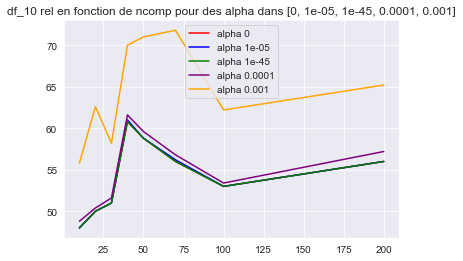

In [42]:
couleurs = ['red','blue','green', 'purple', 'orange']
plt.figure()
for ialpha,alpha in enumerate(l_alpha):
  plt.plot(l_n_components,l_rels_alpha_ncomp_10[ialpha],c=couleurs[ialpha],label=f"alpha {alpha}")
plt.title(f"df_10 rel en fonction de ncomp pour des alpha dans {l_alpha}")
plt.legend()
plt.show()

lapha: 5 lncomp: 8 Z: (8, 5) X: (8, 5) Y: (8, 5)


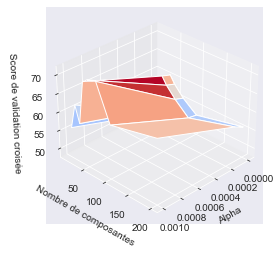

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# création des tableaux de données X, Y et Z
X, Y = np.meshgrid(l_alpha, l_n_components)
Z = np.transpose(l_rels_alpha_ncomp_10)

print(f"lapha: {len(l_alpha)} lncomp: {len(l_n_components)} Z: {Z.shape} X: {X.shape} Y: {Y.shape}")

# tracer la surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

# ajouter des étiquettes
ax.set_xlabel('Alpha')
ax.set_ylabel('Nombre de composantes')
ax.set_zlabel('Score de validation croisée')

# ajuster la vue
ax.view_init(30, 45)

# afficher la figure
plt.show()

[[48.  50.  51.  60.8 58.8 56.  53.  56. ]
 [48.  50.  51.  61.  58.8 56.2 53.  56. ]
 [48.  50.  51.  60.8 58.8 56.  53.  56. ]
 [48.8 50.4 51.6 61.6 59.6 56.8 53.4 57.2]
 [55.8 62.6 58.2 70.  71.  71.8 62.2 65.2]]


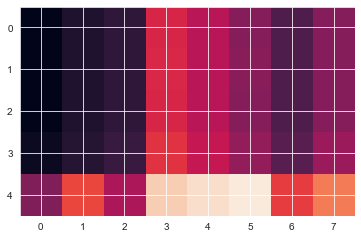

In [44]:
plt.figure()
print(np.array(l_rels_alpha_ncomp_10))
plt.imshow(l_rels_alpha_ncomp_10)
plt.show()

### Nombre de notes minimales = 50

In [45]:
l_rels_alpha_ncomp_50,best_model_50 = executer_reciprocal_rank(n10_interactions_50,splits_50,jeux_existants_50,l_n_components=l_n_components,l_alpha=l_alpha,v=True)

Alpha: 0
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 8887.4 jeux
  moy 22.85  std  3.055732318119504
  par composante:
    10 composantes --> [17, 19, 26, 15, 26]  moy  --> 20.6
    20 composantes --> [24, 27, 26, 23, 28]  moy  --> 25.6
    30 composantes --> [25, 27, 40, 29, 20]  moy  --> 28.2
    40 composantes --> [15, 21, 21, 18, 16]  moy  --> 18.2
    50 composantes --> [20, 27, 22, 21, 24]  moy  --> 22.8
    70 composantes --> [18, 35, 21, 21, 27]  moy  --> 24.4
    100 composantes --> [15, 16, 18, 23, 27]  moy  --> 19.8
    200 composantes --> [29, 21, 18, 30, 18]  moy  --> 23.2
Alpha: 1e-05
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 8887.4 jeux
  moy 22.825000000000003  std  3.0123703291594146
  par composante:
    10 composantes --> [17, 19, 26, 15, 26]  moy  --> 20.6
    20 composantes --> [24, 27, 26, 23, 28]  moy  --> 25.6
    30 composantes --> [24, 27, 40, 29, 20]  moy  --> 28.0
    40 composantes --> [15, 21, 21, 18, 16]

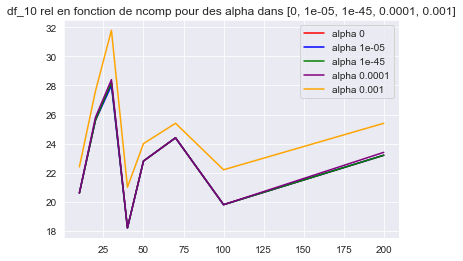

In [46]:
couleurs = ['red','blue','green', 'purple', 'orange']
plt.figure()
for ialpha,alpha in enumerate(l_alpha):
  plt.plot(l_n_components,l_rels_alpha_ncomp_50[ialpha],c=couleurs[ialpha],label=f"alpha {alpha}")
plt.title(f"df_10 rel en fonction de ncomp pour des alpha dans {l_alpha}")
plt.legend()
plt.show()

lapha: 5 lncomp: 8 Z: (8, 5) X: (8, 5) Y: (8, 5)


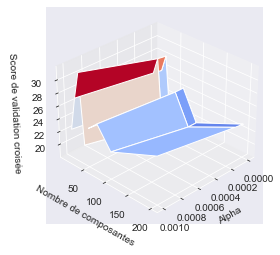

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# création des tableaux de données X, Y et Z
X, Y = np.meshgrid(l_alpha, l_n_components)
Z = np.transpose(l_rels_alpha_ncomp_50)

print(f"lapha: {len(l_alpha)} lncomp: {len(l_n_components)} Z: {Z.shape} X: {X.shape} Y: {Y.shape}")

# tracer la surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

# ajouter des étiquettes
ax.set_xlabel('Alpha')
ax.set_ylabel('Nombre de composantes')
ax.set_zlabel('Score de validation croisée')

# ajuster la vue
ax.view_init(30, 45)

# afficher la figure
plt.show()

[[20.6 25.6 28.2 18.2 22.8 24.4 19.8 23.2]
 [20.6 25.6 28.  18.2 22.8 24.4 19.8 23.2]
 [20.6 25.6 28.2 18.2 22.8 24.4 19.8 23.2]
 [20.6 25.8 28.4 18.2 22.8 24.4 19.8 23.4]
 [22.4 27.6 31.8 21.  24.  25.4 22.2 25.4]]


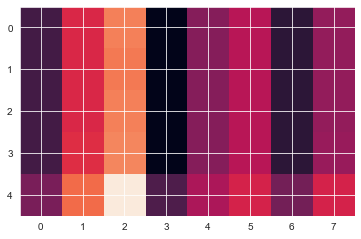

In [48]:
plt.figure()
print(np.array(l_rels_alpha_ncomp_50))
plt.imshow(l_rels_alpha_ncomp_50)
plt.show()

### Nombre de notes minimales = 100

In [49]:
l_rels_alpha_ncomp_100,best_model_100 = executer_reciprocal_rank(n10_interactions_100,splits_100,jeux_existants_100,l_n_components=l_n_components,l_alpha=l_alpha,v=True)
best_model_100

Alpha: 0
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 8261.0 jeux
  moy 12.950000000000001  std  0.9420721840708387
  par composante:
    10 composantes --> [13, 12, 15, 13, 12]  moy  --> 13.0
    20 composantes --> [21, 9, 11, 10, 18]  moy  --> 13.8
    30 composantes --> [10, 16, 14, 18, 12]  moy  --> 14.0
    40 composantes --> [12, 18, 15, 11, 11]  moy  --> 13.4
    50 composantes --> [12, 23, 10, 14, 10]  moy  --> 13.8
    70 composantes --> [13, 8, 12, 12, 12]  moy  --> 11.4
    100 composantes --> [15, 9, 14, 10, 15]  moy  --> 12.6
    200 composantes --> [16, 12, 12, 9, 9]  moy  --> 11.6
Alpha: 1e-05
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 8261.0 jeux
  moy 12.950000000000001  std  0.9420721840708387
  par composante:
    10 composantes --> [13, 12, 15, 13, 12]  moy  --> 13.0
    20 composantes --> [21, 9, 11, 10, 18]  moy  --> 13.8
    30 composantes --> [10, 16, 14, 18, 12]  moy  --> 14.0
    40 composantes --> [12, 18, 15,

(<lightfm.lightfm.LightFM at 0x13b387f70>, 0, 70, 11.4)

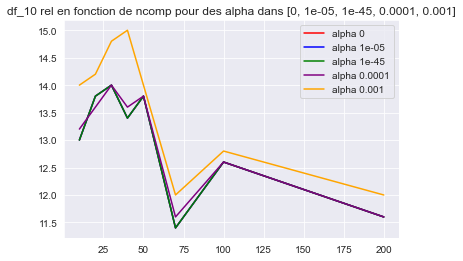

In [50]:
couleurs = ['red','blue','green', 'purple', 'orange']
plt.figure()
for ialpha,alpha in enumerate(l_alpha):
  plt.plot(l_n_components,l_rels_alpha_ncomp_100[ialpha],c=couleurs[ialpha],label=f"alpha {alpha}")
plt.title(f"df_10 rel en fonction de ncomp pour des alpha dans {l_alpha}")
plt.legend()
plt.show()

lapha: 5 lncomp: 8 Z: (8, 5) X: (8, 5) Y: (8, 5)


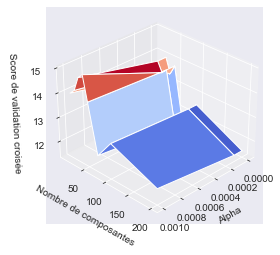

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# création des tableaux de données X, Y et Z
X, Y = np.meshgrid(l_alpha, l_n_components)
Z = np.transpose(l_rels_alpha_ncomp_100)

print(f"lapha: {len(l_alpha)} lncomp: {len(l_n_components)} Z: {Z.shape} X: {X.shape} Y: {Y.shape}")

# tracer la surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

# ajouter des étiquettes
ax.set_xlabel('Alpha')
ax.set_ylabel('Nombre de composantes')
ax.set_zlabel('Score de validation croisée')

# ajuster la vue
ax.view_init(30, 45)

# afficher la figure
plt.show()

[[13.  13.8 14.  13.4 13.8 11.4 12.6 11.6]
 [13.  13.8 14.  13.4 13.8 11.4 12.6 11.6]
 [13.  13.8 14.  13.4 13.8 11.4 12.6 11.6]
 [13.2 13.6 14.  13.6 13.8 11.6 12.6 11.6]
 [14.  14.2 14.8 15.  14.  12.  12.8 12. ]]


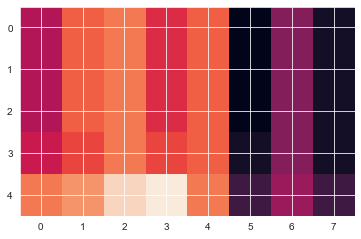

In [52]:
plt.figure()
print(np.array(l_rels_alpha_ncomp_100))
plt.imshow(l_rels_alpha_ncomp_100)
plt.show()

### Nombre de notes minimales = 200

In [53]:
l_rels_alpha_ncomp_200,best_model_200 = executer_reciprocal_rank(n10_interactions_200,splits_200,jeux_existants_200,l_n_components=l_n_components,l_alpha=l_alpha,v=True)
best_model_200

Alpha: 0
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 7230.8 jeux
  moy 7.9750000000000005  std  1.046123797645384
  par composante:
    10 composantes --> [6, 11, 10, 10, 9]  moy  --> 9.2
    20 composantes --> [6, 7, 6, 8, 12]  moy  --> 7.8
    30 composantes --> [10, 10, 10, 8, 6]  moy  --> 8.8
    40 composantes --> [8, 11, 10, 9, 6]  moy  --> 8.8
    50 composantes --> [6, 7, 8, 10, 6]  moy  --> 7.4
    70 composantes --> [8, 7, 7, 6, 7]  moy  --> 7.0
    100 composantes --> [6, 5, 6, 6, 7]  moy  --> 6.0
    200 composantes --> [9, 7, 9, 10, 9]  moy  --> 8.8
Alpha: 1e-05
  Nombres de composantes:
  [10, 20, 30, 40, 50, 70, 100, 200]
  sur 7230.8 jeux
  moy 7.9750000000000005  std  1.046123797645384
  par composante:
    10 composantes --> [6, 11, 10, 10, 9]  moy  --> 9.2
    20 composantes --> [6, 7, 6, 8, 12]  moy  --> 7.8
    30 composantes --> [10, 10, 10, 8, 6]  moy  --> 8.8
    40 composantes --> [8, 11, 10, 9, 6]  moy  --> 8.8
    50 composantes --> [

(<lightfm.lightfm.LightFM at 0x13acf0550>, 0, 100, 6.0)

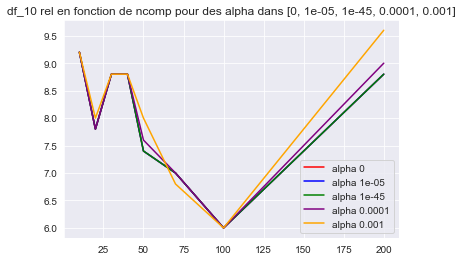

In [54]:
couleurs = ['red','blue','green', 'purple', 'orange']
plt.figure()
for ialpha,alpha in enumerate(l_alpha):
  plt.plot(l_n_components,l_rels_alpha_ncomp_200[ialpha],c=couleurs[ialpha],label=f"alpha {alpha}")
plt.title(f"df_10 rel en fonction de ncomp pour des alpha dans {l_alpha}")
plt.legend()
plt.show()

lapha: 5 lncomp: 8 Z: (8, 5) X: (8, 5) Y: (8, 5)


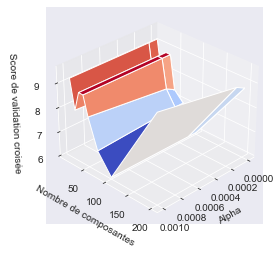

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# création des tableaux de données X, Y et Z
X, Y = np.meshgrid(l_alpha, l_n_components)
Z = np.transpose(l_rels_alpha_ncomp_200)

print(f"lapha: {len(l_alpha)} lncomp: {len(l_n_components)} Z: {Z.shape} X: {X.shape} Y: {Y.shape}")

# tracer la surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm')

# ajouter des étiquettes
ax.set_xlabel('Alpha')
ax.set_ylabel('Nombre de composantes')
ax.set_zlabel('Score de validation croisée')

# ajuster la vue
ax.view_init(30, 45)

# afficher la figure
plt.show()

[[9.2 7.8 8.8 8.8 7.4 7.  6.  8.8]
 [9.2 7.8 8.8 8.8 7.4 7.  6.  8.8]
 [9.2 7.8 8.8 8.8 7.4 7.  6.  8.8]
 [9.2 7.8 8.8 8.8 7.6 7.  6.  9. ]
 [9.2 8.  8.8 8.8 8.  6.8 6.  9.6]]


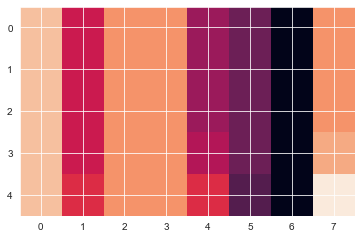

In [56]:
plt.figure()
print(np.array(l_rels_alpha_ncomp_200))
plt.imshow(l_rels_alpha_ncomp_200)
plt.show()

### Visualisation avec TSNE

In [57]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def tsne_best_model(model):

    embeddings = model[0].item_embeddings
        # clustering
    nb_clust = 10
    kmeans = KMeans(n_clusters=nb_clust, random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    # Initilisation de tsne, avec metric cosine
    tsne = TSNE(random_state = 0, n_iter = 1000, metric ='cosine')

    # Fit and transform
    embeddings2d = tsne.fit_transform(embeddings)

    clusters2d = []
    for cl in range(nb_clust):
        icls = clusters==cl
        clust = embeddings2d[icls]
        clusters2d.append(clust)

    # Set figsize
    fig, ax = plt.subplots(figsize=(10,8))

    # Scatter points, set alpha low to make points translucent
    for clust in clusters2d:
        X,Y = clust[:,0], clust[:,1]
        ax.scatter(X, Y, alpha=.1)

    plt.title('Scatter plot of games using t-SNE')
    plt.show()
    


/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


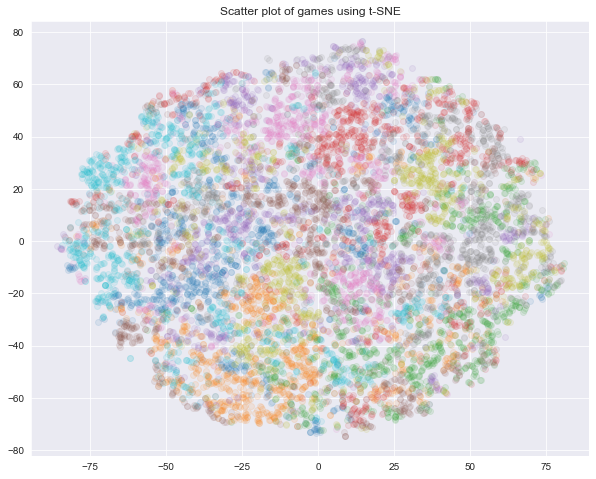

In [58]:
tsne_best_model(best_model_10)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


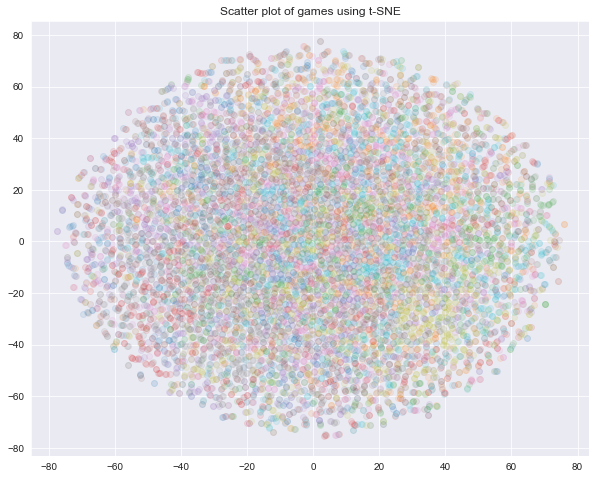

In [59]:
tsne_best_model(best_model_50)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


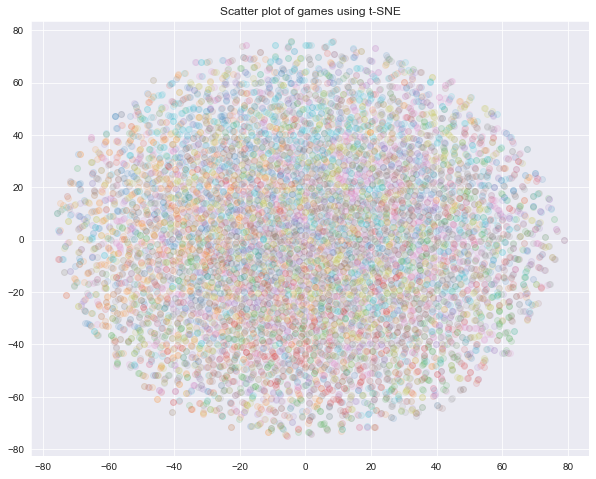

In [60]:
tsne_best_model(best_model_100)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


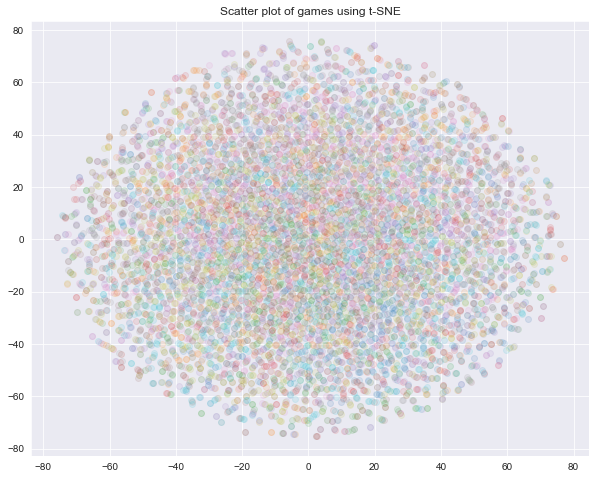

In [61]:
tsne_best_model(best_model_200)

## Si l'on considère une note >= 7 comme une interaction

In [62]:
# (c) Create the interaction matrices
n7_interactions_10,n7_interactions_50,n7_interactions_100,n7_interactions_200 = [],[],[],[]
for ip in range(len(splits_10)):
    dataset = dataset_10[ip]
    X_train,X_test,je = splits_10[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 7) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 7)  # We only consider 5's as interactions
    )
    n7_interactions_10.append((train_interactions,test_interactions))
    
    dataset = dataset_50[ip]
    X_train,X_test,je = splits_50[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 7) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 7)  # We only consider 5's as interactions
    )
    n7_interactions_50.append((train_interactions,test_interactions))
    
    dataset = dataset_100[ip]
    X_train,X_test,je = splits_100[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 7) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 7)  # We only consider 5's as interactions
    )
    n7_interactions_100.append((train_interactions,test_interactions))
    
    dataset = dataset_200[ip]
    X_train,X_test,je = splits_200[ip]
    merged = X_test.merge(X_train[['author', 'title']], on=['author', 'title'], how='left', indicator=True)
    X_test = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
    (train_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_train.itertuples() if x.note >= 7) # We only consider 5's as interactions
    ) 
    (test_interactions, weights) = dataset.build_interactions(
        ((x.author, x.title) for x in X_test.itertuples() if x.note >= 7)  # We only consider 5's as interactions
    )
    n7_interactions_200.append((train_interactions,test_interactions))

### Nombre de notes minimales = 10

In [64]:
l_rels_alpha_ncomp_10,best_model_10 = executer_reciprocal_rank(n7_interactions_10,splits_10,jeux_existants_10,l_n_components=l_n_components,l_alpha=l_alpha,v=False)
best_model_10

(<lightfm.lightfm.LightFM at 0x139bff3a0>, 0, 50, 36.8)

### Nombre de notes minimales = 50

In [65]:
l_rels_alpha_ncomp_50,best_model_50 = executer_reciprocal_rank(n7_interactions_50,splits_50,jeux_existants_50,l_n_components=l_n_components,l_alpha=l_alpha,v=False)
best_model_50

(<lightfm.lightfm.LightFM at 0x12fddd310>, 0, 10, 9.8)

### Nombre de notes minimales = 100

In [66]:
l_rels_alpha_ncomp_100,best_model_100 = executer_reciprocal_rank(n7_interactions_100,splits_100,jeux_existants_100,l_n_components=l_n_components,l_alpha=l_alpha,v=False)
best_model_100

(<lightfm.lightfm.LightFM at 0x139bfffd0>, 0, 40, 5.0)

### Nombre de notes minimales = 200

In [67]:
l_rels_alpha_ncomp_200,best_model_200 = executer_reciprocal_rank(n7_interactions_200,splits_200,jeux_existants_200,l_n_components=l_n_components,l_alpha=l_alpha,v=False)
best_model_200

(<lightfm.lightfm.LightFM at 0x139c17610>, 0, 30, 3.0)

En considérant que si un utilisateur met une note >= 7 il aime le film les performances de la recommendations sont nettement améliorées, pas beaucoup mais c'est quand même significatif.

- pour >= 10 on a **45.4** 
- pour >= 50 on a **3.2** 
- pour >= 100 on a **6.0** 
- pour >= 200 on a **3.4** 

### Visualisation avec TSNE

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


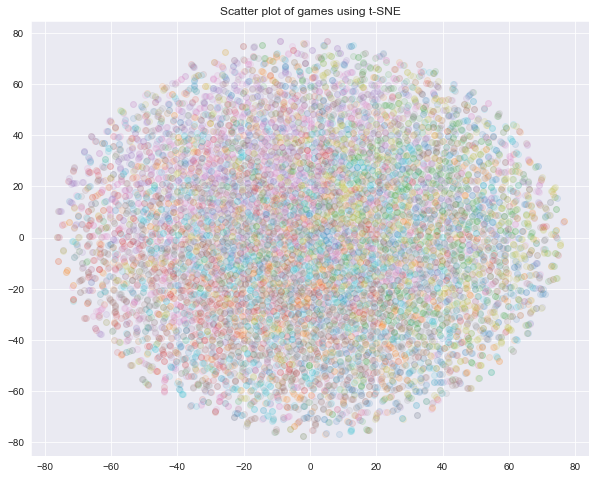

In [68]:
tsne_best_model(best_model_10)


/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


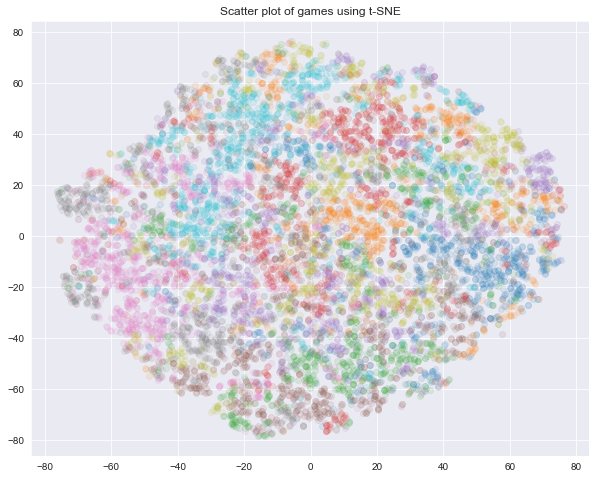

In [69]:
tsne_best_model(best_model_50)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


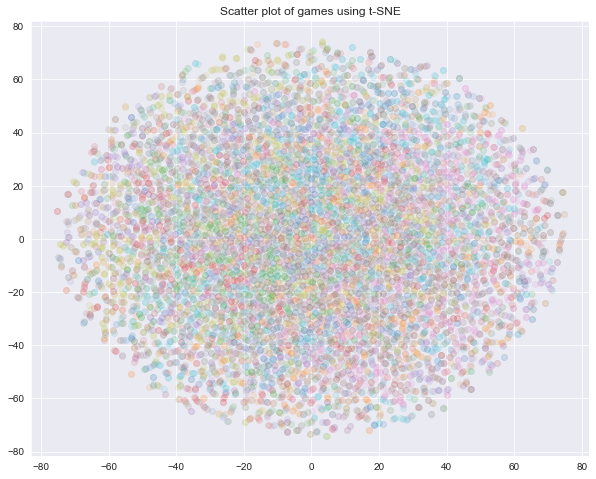

In [70]:
tsne_best_model(best_model_100)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


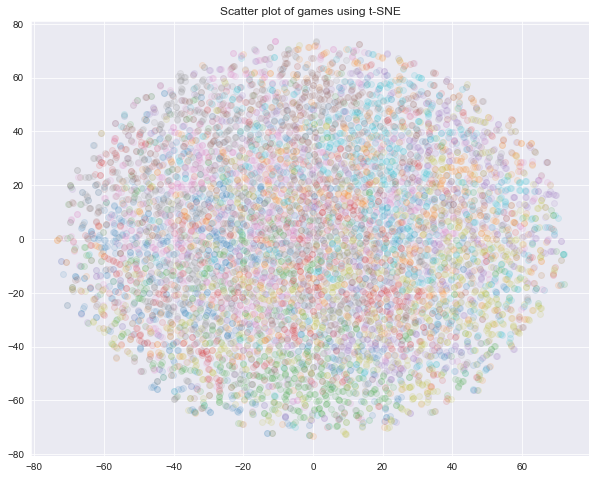

In [71]:
tsne_best_model(best_model_200)